# Homework 1: Classifiers

# Linear Support Vector Machine (SVM) classifier

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Load and preprocess CIFAR-10 dataset

In [2]:
from keras.datasets import cifar10

def get_CIFAR10_data(num_training=49000, num_validation=1000,
                     num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    
    # All the data comes in the uint8 format, so we need to convert
    # it to floats so that we compute numbers greater than 255.
    X_train = X_train.astype(np.float)
    X_test = X_test.astype(np.float)
    # Also, for convenience we flatten the class arrays.
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    # Split the data into train, val, and test sets. In addition we will
    # create a small development set as a subset of the training data;
    # we can use this for development so our code runs faster.
    
    # Our validation set will be num_validation points from the original
    # training set.
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    
    # Our training set will be the first num_train points from the original
    # training set.
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    
    # We will also make a development set, which is a small subset of
    # the training set.
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # We use the first num_test points of the original test set as our
    # test set.
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # third: append the bias dimension of ones (i.e. bias trick) so that our SVM
    # only has to worry about optimizing a single weight matrix W.
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Using TensorFlow backend.


170500096/170498071 [==============================] - 6s 0us/step
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Define a naive SVM classifier loss function

Next we define the SVM loss function.  This will be a naive implementation using loops.  Most of the code for this loss function already exists, but you will need to write code of your own to finish it.  Follow the instructions in the TODO section.

Recall that the contribution of a training point $(x_i, y_i)$ to the SVM loss function is

$$L_i = \sum_{j \neq y_i} \max(0, s_j− s_{y_i} + \Delta)$$

where $\Delta$ is the *margin*.  The loss function encourages the score $s_{y_i}$ of the correct class $y_i$ to be larger than any of the other scores $s_j$ by at least the margin $\Delta$.  The score $s$ is parametrized by
a linear function $s_j = xW_j$ where $x$ is a single data sample and $W_j$ is the $j$th column of $W$.

![margin](http://cs231n.github.io/assets/margin.jpg)

In [0]:
def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
        that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    dW = np.zeros(W.shape) # initialize the gradient as zero

    # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1 # note delta = 1
            if margin > 0:
                loss += margin
                dW[:, j] += X[i]/num_train
                dW[:, y[i]] -= X[i]/num_train

    # Right now the loss is a sum over all training examples, but we want it
    # to be an average instead so we divide by num_train.
    loss /= num_train

    # Add regularization to the loss.
    loss += reg * np.sum(W * W)
    dW += 2*reg*W
    
    #############################################################################
    # TODO:                                                                     #                                                               #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather than first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################


    return loss, dW

In [5]:
# Evaluate the naive implementation of the SVM loss
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.079765


To check that you have implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [6]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for i in range(num_checks):
        ix = tuple([np.random.randint(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))
        
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 20.407458 analytic: 20.382183, relative error: 6.196557e-04
numerical: -6.570420 analytic: -6.570420, relative error: 4.456222e-12
numerical: -10.695665 analytic: -10.804405, relative error: 5.057641e-03
numerical: 2.308603 analytic: 2.308603, relative error: 6.631455e-11
numerical: -26.079796 analytic: -26.018813, relative error: 1.170519e-03
numerical: -5.044675 analytic: -4.991408, relative error: 5.307522e-03
numerical: 34.501760 analytic: 34.498443, relative error: 4.807802e-05
numerical: 14.741779 analytic: 14.741779, relative error: 8.014211e-12
numerical: 21.573629 analytic: 21.573629, relative error: 2.410721e-11
numerical: -51.604890 analytic: -51.604890, relative error: 7.898118e-12
numerical: 3.670247 analytic: 3.670247, relative error: 1.917386e-11
numerical: -10.146567 analytic: -10.146567, relative error: 1.168065e-12
numerical: -17.284875 analytic: -17.316072, relative error: 9.016204e-04
numerical: 13.330796 analytic: 13.330796, relative error: 5.640296e-12


### Inline Question 1:
It is possible that once in a while a value in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *A discrepancy may be caused when the loss function is not differentiable at some points. The formula for the numerical gradient is $\frac{df(x)}{dx}=\frac{f(x+h)−f(x−h)}{2h}$. If $(x+h)$ is greater than 0 while $(x-h)$ is less than 0, the SVM loss function $max(0, x)$ could cause an analytical gradient error.*

## Define a vectorized SVM classifier loss function

Next we define the vectorized (i.e. no loops) version of the SVM loss function.  Most of the code for this loss function already exists, but you will need to write code of your own to finish it.  Follow the instructions in the TODO section.

In [0]:
def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized form of the SVM loss, storing the result in loss.  #
    #                                                                           #
    #############################################################################
    # (N, D) * (D, C) = (N, C)
    scores = X.dot(W)
    N, C = scores.shape
    scores_y = scores[np.arange(N), y].reshape(-1, 1) # (N, 1)
    l_i = np.maximum(0, scores - scores_y + 1) # (N,C) - (N,1)
    l_i[np.arange(N), y] = 0
    loss = np.sum(l_i)/N + reg * np.sum(W * W)
    #############################################################################
    #                                                         END OF YOUR CODE  #
    #############################################################################


    #############################################################################
    # TODO:                                                                      #                                                                   
    # Implement a vectorized version of the gradient for the SVM loss,           #
    # storing the result in dW.                                                  #                                               
    #                                                                            #                                                                         
    # Hint: Instead of computing the gradient from scratch, it may be easier     #
    # to reuse some of the intermediate values that you used to compute the      #
    # loss.                                                                      #                                                                   
    #############################################################################
    count_matrix = (l_i > 0).astype(int) # (N, C)
    count_matrix[np.arange(N), y] = -np.sum(count_matrix, axis=1) # ex. [1,1, -2, 0]
    dW = X.T.dot(count_matrix)/N + 2 * reg * W # (D, N) (N, C) = (D, C)
    #############################################################################
    #                                                         END OF YOUR CODE  #                                                          
    #############################################################################

    return loss, dW

In [30]:
# Evaluate the naive implementation of the SVM loss
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

# Evaluate the vectorized implementation of the SVM loss
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.079765e+00 computed in 0.198218s
Vectorized loss: 9.079765e+00 computed in 0.008908s
difference: -0.000000


In [31]:
# Evaluate the naive implementation of the SVM gradients

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.201069s
Vectorized loss and gradient: computed in 0.008862s
difference: 0.000000


## Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.  Follow the instructions in the TODO sections.

In [0]:
class SVM(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
                        batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
            training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
            means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            batch_indices = np.random.choice(num_train, batch_size, replace=False)
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]
            #########################################################################
            #                                             END OF YOUR CODE          #
            #########################################################################

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            self.W -= learning_rate * grad
            #########################################################################
            #                                             END OF YOUR CODE          #
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
            training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
            array of length N, and each element is an integer giving the predicted
            class.
        """
        y_pred = np.zeros(X.shape[0])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        scores = X.dot(self.W)
        y_pred = np.argmax(scores, axis=1)
        ###########################################################################
        #                                                     END OF YOUR CODE    #
        ###########################################################################
        return y_pred
    
    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative. 
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
            data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

In [73]:
# Implement SGD in the function SVM.train() and then run it with the code below.
svm = SVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 787.839891
iteration 100 / 1500: loss 288.554595
iteration 200 / 1500: loss 108.565695
iteration 300 / 1500: loss 42.429726
iteration 400 / 1500: loss 19.312421
iteration 500 / 1500: loss 10.752988
iteration 600 / 1500: loss 6.617623
iteration 700 / 1500: loss 6.165984
iteration 800 / 1500: loss 5.400399
iteration 900 / 1500: loss 5.566508
iteration 1000 / 1500: loss 5.609012
iteration 1100 / 1500: loss 5.151386
iteration 1200 / 1500: loss 5.595381
iteration 1300 / 1500: loss 5.609010
iteration 1400 / 1500: loss 5.079348
That took 8.999645s


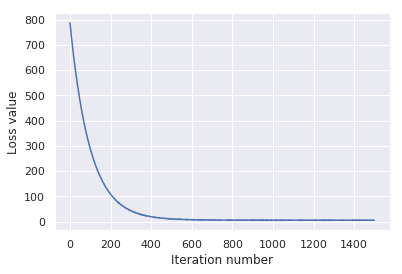

In [74]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [75]:
# Write the SVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.372735
validation accuracy: 0.385000


In [0]:
from itertools import product
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1.4e-7, 1.5e-7, 1.6e-7]
regularization_strengths = np.arange(5, 25)*1e4

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for l_rate, reg_strength in product(learning_rates, regularization_strengths):
    svm = SVM()
    svm.train(X_train, y_train, learning_rate=l_rate, reg=reg_strength, num_iters=1500, verbose=False)
    train_acc = np.mean(y_train == svm.predict(X_train))
    val_acc = np.mean(y_val == svm.predict(X_val))
    
    results[(l_rate, reg_strength)] = (train_acc, val_acc)
    if val_acc > best_val:
        best_val = val_acc
        best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

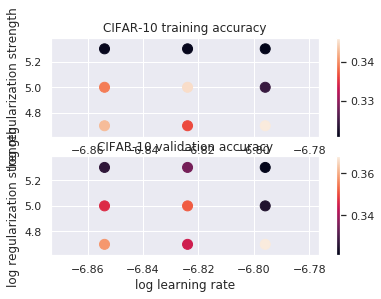

In [82]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [83]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.347000


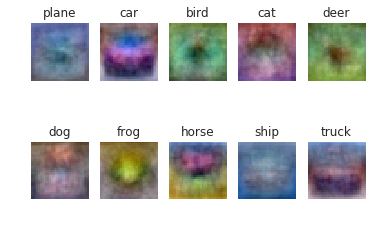

In [84]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** The visualized SVM weights look like they have the average outline of the objects. This classifier basically tries to create a filter representative of a class and predicts the class whose filter most closely resembles the example.

*Many thanks to Stanford CS231n for permission to use their materials!*